Step 1, Loss: 3.2355971336364746
Step 2, Loss: 3.3311569690704346
Step 3, Loss: 3.3021514415740967
Step 4, Loss: 3.356022596359253
Step 5, Loss: 3.295057773590088
Step 6, Loss: 3.332509756088257
Step 7, Loss: 3.333594560623169
Step 8, Loss: 3.322805404663086
Step 9, Loss: 3.2997334003448486
Step 10, Loss: 3.2887110710144043
Step 11, Loss: 3.2975518703460693
Step 12, Loss: 3.292133092880249
Step 13, Loss: 3.3446362018585205
Step 14, Loss: 3.294689416885376
Step 15, Loss: 3.257690668106079
Step 16, Loss: 3.29628586769104
Step 17, Loss: 3.2868454456329346
Step 18, Loss: 3.276792049407959
Step 19, Loss: 3.3309214115142822
Step 20, Loss: 3.2780802249908447
Step 21, Loss: 3.2743873596191406
Step 22, Loss: 3.2816781997680664
Step 23, Loss: 3.2967042922973633
Step 24, Loss: 3.3971049785614014
Step 25, Loss: 3.355710506439209
Step 26, Loss: 3.335989236831665
Step 27, Loss: 3.195284366607666
Step 28, Loss: 3.3151979446411133
Step 29, Loss: 3.3443801403045654
Step 30, Loss: 3.3444101810455322
Ste

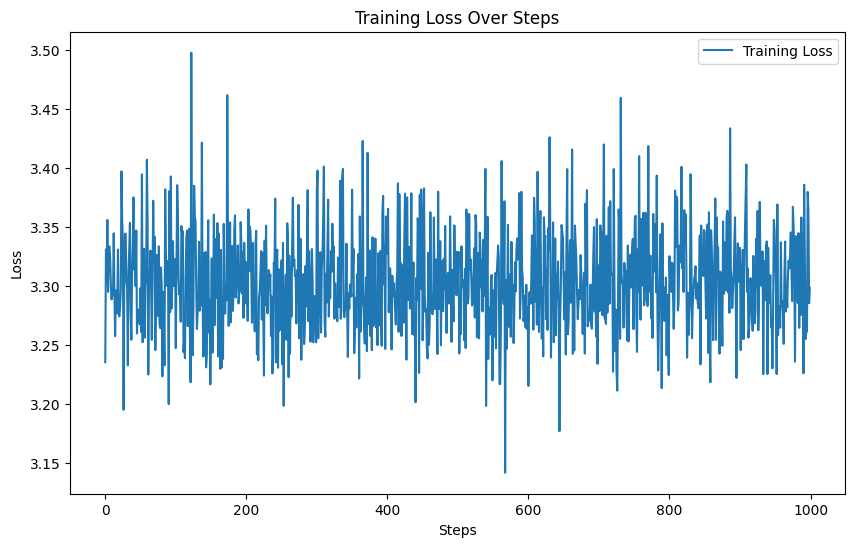

In [26]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import numpy as np
from scipy.sparse import random
from scipy.sparse.linalg import eigs  # For sparse eigenvalue computation
import matplotlib.pyplot as plt

class SingleLayerNN(nn.Module):
    def __init__(self, input_size, hidden_size ,output_size=65):
        super(SingleLayerNN, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)
        self.create_reservoir(input_size)
        self.input_size = input_size
    
    def reservoir_forward(self, input, targets=None):
        xb_hot = tensor_to_one_hot(input, num_classes=self.input_size)
        B, T, C = xb_hot.shape
        output = torch.zeros(B, T, 65)

        if T > 1:
            for b in range(T - 1):
                xb_hot[:, b, :] = torch.atan(xb_hot[:, b, :] @ self.W_res)
                xb_hot[:, b + 1, :] += xb_hot[:, b, :]
            xb_hot[:, T - 1, :] = torch.atan(xb_hot[:, T - 2, :] @ self.W_res)
        else:
            xb_hot[:, 0, :] = torch.atan(xb_hot[:, 0, :] @ self.W_res)

        output, loss = self(xb_hot, targets)

        return output, loss

    def forward(self, x, targets=None): 
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        output = torch.relu(x)

        if targets == None:
            loss = None
        else:
            B, T, C = output.shape
            output = output.view(B*T, C) 
            targets = targets.view(B*T)
            loss = F.cross_entropy(output, targets.long())

        return output, loss
    
    def create_reservoir(self, N_res, eta=0.01):
        def uniform_rvs(size):
            return np.random.uniform(low=-1.0, high=1.0, size=size)
        W = random(N_res, N_res, density=eta, format='csr', data_rvs=uniform_rvs)
        W_dense = W.toarray()
        #Calculate the max eigenvalue and find the max
        max_eigenvalue = eigs(W, k=1, which='LM', return_eigenvectors=False)[0].real
        # Normalize W to get W_res
        rho = 0.9
        W_res = rho * (W / max_eigenvalue)
        W_res = torch.from_numpy(W_dense)
        W_res = W_res.to(torch.float32)
        self.W_res = W_res
        return 0
    
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self.reservoir_forward(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

def tensor_to_one_hot(input_tensor, num_classes=1000):
    """
    One hot encode all the data in a batch
    """
    batch_size, seq_len = input_tensor.shape
    # Create a zero tensor of shape (batch_size, seq_len, num_classes)
    one_hot_tensor = torch.zeros((batch_size, seq_len, num_classes), dtype=torch.float32)
    # Fill the one-hot tensor
    for i in range(batch_size):
        for j in range(seq_len):
            one_hot_tensor[i, j, int(input_tensor[i, j])] = 1

    return one_hot_tensor

def get_batch(split, block_size, batch_size):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

if __name__ == "__main__":
    
    with open('tinyshakespeare.txt', 'r', encoding='utf-8') as f:
        text = f.read()

    chars = sorted(list(set(text)))
    vocab_size = len(chars)
    stoi = { ch:i for i,ch in enumerate(chars) }
    itos = { i:ch for i,ch in enumerate(chars) }
    encode = lambda s: [stoi[c] for c in s] 
    decode = lambda l: ''.join([itos[i] for i in l]) 
    data = torch.tensor(encode(text), dtype=torch.float)
    n = int(0.9*len(data)) 
    train_data = data[:n]
    val_data = data[n:]

    # model = SingleLayerNN(input_size=1000, hidden_size=300 ,output_size=65)
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-6)


    # Initialize a list to store the loss values
    loss_values = []

    batch_size = 8
    block_size = 512
    for steps in range(1000):  # Increase the number of steps for good results...

        # Sample a batch of data
        xb, yb = get_batch('train', block_size, batch_size)

        # Evaluate the loss
        logits, loss = model.reservoir_forward(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Append the loss value to the list
        loss_values.append(loss.item())

        # Print the loss value
        print(f"Step {steps + 1}, Loss: {loss.item()}")

    # Plot the loss values
    plt.figure(figsize=(10, 6))
    plt.plot(loss_values, label='Training Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Steps')
    plt.legend()
    plt.show()